### 1.Import Libraries

In [1]:
# !pip install feature_engine

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer,
    StandardScaler,
    OrdinalEncoder
)
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures
import matplotlib.pyplot as plt
import warnings

### 2. Display Settings

In [3]:
pd.set_option('display.max_columns',None)

In [4]:
sklearn.set_config(transform_output='pandas') # to get output in dataframe

In [5]:
warnings.filterwarnings('ignore')

### 3. Read the Data

In [6]:
path = r"D:\Ml projects\flight\data\train.csv"
train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-15,Delhi,Cochin,11:25:00,01:30:00,845,1.0,No Info,5883
1,Jet Airways,2019-06-09,Delhi,Cochin,22:50:00,04:25:00,335,1.0,In-flight meal not included,10262
2,Indigo,2019-03-15,Delhi,Cochin,14:30:00,17:35:00,185,0.0,No Info,5895
3,Indigo,2019-05-06,Banglore,Delhi,23:30:00,02:20:00,170,0.0,No Info,4077
4,Jet Airways,2019-04-01,Kolkata,Banglore,08:25:00,18:15:00,590,1.0,In-flight meal not included,7064
...,...,...,...,...,...,...,...,...,...,...
635,Indigo,2019-04-01,Kolkata,Banglore,11:30:00,14:05:00,155,0.0,No Info,4174
636,Air India,2019-05-06,Kolkata,Banglore,09:50:00,23:15:00,805,2.0,No Info,14120
637,Jet Airways,2019-05-06,Kolkata,Banglore,08:25:00,18:15:00,590,1.0,In-flight meal not included,10844
638,Jet Airways,2019-06-09,Delhi,Cochin,14:35:00,04:25:00,830,2.0,No Info,13376


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [8]:
x_train = train.drop(columns='price')
y_train = train.price.copy()

### 4. Transformation Operation

### 4.1 airline

In [9]:
x_train.airline

0           Indigo
1      Jet Airways
2           Indigo
3           Indigo
4      Jet Airways
          ...     
635         Indigo
636      Air India
637    Jet Airways
638    Jet Airways
639    Jet Airways
Name: airline, Length: 640, dtype: object

In [10]:
air_transformer = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('grouper',RareLabelEncoder(tol=0.1,replace_with='Other',n_categories=2)),
    ('encoder',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
    
])

air_transformer.fit_transform(x_train.loc[:,['airline']])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0
636,1.0,0.0,0.0,0.0,0.0
637,0.0,0.0,1.0,0.0,0.0
638,0.0,0.0,1.0,0.0,0.0


### 4.2 date_of_journey

In [11]:
x_train.date_of_journey

0      2019-06-15
1      2019-06-09
2      2019-03-15
3      2019-05-06
4      2019-04-01
          ...    
635    2019-04-01
636    2019-05-06
637    2019-05-06
638    2019-06-09
639    2019-06-12
Name: date_of_journey, Length: 640, dtype: object

In [12]:
feature_to_extract = ['week','day_of_week','month','quarter_start','quarter_end','day_of_year']

doj_transformer = Pipeline(steps =[
    ('dt',DatetimeFeatures(features_to_extract=feature_to_extract,yearfirst=True, format='mixed')),
    ('scaler',MinMaxScaler())
])

doj_transformer.fit_transform(x_train.loc[:,['date_of_journey']])

,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_month,date_of_journey_quarter_start,date_of_journey_quarter_end,date_of_journey_day_of_year
0,0.882353,0.833333,1.000000,0.0,0.0,0.898305
1,0.823529,1.000000,1.000000,0.0,0.0,0.847458
2,0.117647,0.666667,0.000000,0.0,0.0,0.118644
3,0.588235,0.000000,0.666667,0.0,0.0,0.559322
4,0.294118,0.000000,0.333333,1.0,0.0,0.262712
...,...,...,...,...,...,...
635,0.294118,0.000000,0.333333,1.0,0.0,0.262712
636,0.588235,0.000000,0.666667,0.0,0.0,0.559322
637,0.588235,0.000000,0.666667,0.0,0.0,0.559322
638,0.823529,1.000000,1.000000,0.0,0.0,0.847458


### 4.3 Source and Destination

In [13]:
x_train.source

0         Delhi
1         Delhi
2         Delhi
3      Banglore
4       Kolkata
         ...   
635     Kolkata
636     Kolkata
637     Kolkata
638       Delhi
639     Kolkata
Name: source, Length: 640, dtype: object

In [14]:
x_train.destination

0        Cochin
1        Cochin
2        Cochin
3         Delhi
4      Banglore
         ...   
635    Banglore
636    Banglore
637    Banglore
638      Cochin
639    Banglore
Name: destination, Length: 640, dtype: object

In [15]:
location_subset = x_train.loc[:,['source','destination']]
location_subset

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Delhi,Cochin
3,Banglore,Delhi
4,Kolkata,Banglore
...,...,...
635,Kolkata,Banglore
636,Kolkata,Banglore
637,Kolkata,Banglore
638,Delhi,Cochin


In [16]:
location_pipe1 = Pipeline(steps=[
    ('grouper',RareLabelEncoder(tol=0.1,replace_with='Other',n_categories=2)),
    ('encode',MeanEncoder()),
    ('scaler',PowerTransformer())
    
])
location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,1.053533,1.047943
1,1.053533,1.047943
2,1.053533,1.047943
3,-0.838946,-1.755258
4,-0.292450,-0.325060
...,...,...
635,-0.292450,-0.325060
636,-0.292450,-0.325060
637,-0.292450,-0.325060
638,1.053533,1.047943


In [17]:
np.union1d(
    x_train.source.unique(),
    x_train.destination.unique()

)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [18]:
def is_north(x):
    columns = x.columns.to_list()
    north_cities = ['Delhi','Kolkata','Mumbai','New Delhi']
    return (
        x
        .assign(**{
            f'{col}_is_north':x.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0
...,...,...
635,1,0
636,1,0
637,1,0
638,1,0


In [19]:
location_transformer =  FeatureUnion(transformer_list=[
    ('part1',location_pipe1),
    ('part2',FunctionTransformer(func=is_north))
])
location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,1.053533,1.047943,1,0
1,1.053533,1.047943,1,0
2,1.053533,1.047943,1,0
3,-0.838946,-1.755258,0,1
4,-0.292450,-0.325060,1,0
...,...,...,...,...
635,-0.292450,-0.325060,1,0
636,-0.292450,-0.325060,1,0
637,-0.292450,-0.325060,1,0
638,1.053533,1.047943,1,0


### 4.4 Dep_time and arr_time

In [20]:
x_train.dep_time

0      11:25:00
1      22:50:00
2      14:30:00
3      23:30:00
4      08:25:00
         ...   
635    11:30:00
636    09:50:00
637    08:25:00
638    14:35:00
639    08:25:00
Name: dep_time, Length: 640, dtype: object

In [21]:
x_train.arrival_time

0      01:30:00
1      04:25:00
2      17:35:00
3      02:20:00
4      18:15:00
         ...   
635    14:05:00
636    23:15:00
637    18:15:00
638    04:25:00
639    16:20:00
Name: arrival_time, Length: 640, dtype: object

In [22]:
time_subset = x_train.loc[:,['dep_time','arrival_time']]
time_subset

,dep_time,arrival_time
0,11:25:00,01:30:00
1,22:50:00,04:25:00
2,14:30:00,17:35:00
3,23:30:00,02:20:00
4,08:25:00,18:15:00
...,...,...
635,11:30:00,14:05:00
636,09:50:00,23:15:00
637,08:25:00,18:15:00
638,14:35:00,04:25:00


In [23]:
time_pipe1 = Pipeline(steps =[
    ('dt',DatetimeFeatures(features_to_extract=['hour','minute'])),
    ('scaler',MinMaxScaler())
])
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.478261,0.454545,0.043478,0.545455
1,0.956522,0.909091,0.173913,0.454545
2,0.608696,0.545455,0.739130,0.636364
3,1.000000,0.545455,0.086957,0.363636
4,0.347826,0.454545,0.782609,0.272727
...,...,...,...,...
635,0.478261,0.545455,0.608696,0.090909
636,0.391304,0.909091,1.000000,0.272727
637,0.347826,0.454545,0.782609,0.272727
638,0.608696,0.636364,0.173913,0.454545


In [24]:
def part_of_day(x,morning=4,noon=12,eve=16,night=20):
    columns = x.columns.to_list()
    x_temp =x.assign(**{
        col:pd.to_datetime(x.loc[:,col]).dt.hour
        for col in columns
    })
    return (
        x_temp
        .assign(**{
            f"{col}_part_of_day":np.select(
            [x_temp.loc[:,col].between(morning,noon,inclusive='left'),
             x_temp.loc[:,col].between(noon,eve,inclusive='left'),
             x_temp.loc[:,col].between(eve,night,inclusive='left')],
            ['morning','afternoon','evening'],
            default = 'night'
            )
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,night
1,night,morning
2,afternoon,evening
3,night,night
4,morning,evening
...,...,...
635,morning,afternoon
636,morning,night
637,morning,evening
638,afternoon,morning


In [25]:
time_pipe2 = Pipeline(steps=[
    ('part',FunctionTransformer(func=part_of_day)),
    ('encoder',CountFrequencyEncoder()),
    ('scale',MinMaxScaler())
])
time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,1.000000
1,0.015625,0.870968
2,0.000000,0.709677
3,0.015625,1.000000
4,1.000000,0.709677
...,...,...
635,1.000000,0.000000
636,1.000000,1.000000
637,1.000000,0.709677
638,0.000000,0.870968


In [26]:
time_transformer = FeatureUnion(transformer_list=[
    ('part1',time_pipe1),
    ('part2',time_pipe2)
])
time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.478261,0.454545,0.043478,0.545455,1.000000,1.000000
1,0.956522,0.909091,0.173913,0.454545,0.015625,0.870968
2,0.608696,0.545455,0.739130,0.636364,0.000000,0.709677
3,1.000000,0.545455,0.086957,0.363636,0.015625,1.000000
4,0.347826,0.454545,0.782609,0.272727,1.000000,0.709677
...,...,...,...,...,...,...
635,0.478261,0.545455,0.608696,0.090909,1.000000,0.000000
636,0.391304,0.909091,1.000000,0.272727,1.000000,1.000000
637,0.347826,0.454545,0.782609,0.272727,1.000000,0.709677
638,0.608696,0.636364,0.173913,0.454545,0.000000,0.870968


### 4.5 duration

In [27]:
x_train.duration

0      845
1      335
2      185
3      170
4      590
      ... 
635    155
636    805
637    590
638    830
639    475
Name: duration, Length: 640, dtype: int64

In [28]:
duration_subset = x_train.loc[:,['duration']]
duration_subset

,duration
0,845
1,335
2,185
3,170
4,590
...,...
635,155
636,805
637,590
638,830


In [29]:
(
    x_train
    .duration
    .quantile([0.25,0.50,0.75])
    .values
    .reshape(-1,1)
    .shape
    
)

(3, 1)

In [51]:
class RBFpercentileSimilarity(BaseEstimator,TransformerMixin):
    def __init__(self,variables=None,percentiles=[0.25,0.50,0.75],gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma
        
    def fit(self,x,y=None):
        if not self.variables:
            self.variables = x.select_dtypes(include='number').columns.to_list()
            
        self.reference_values_ = {
            col:(
                x
                .loc[:,col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)
            )
            for col in self.variables
        }
        
        return self
    
    def transform(self,x):
        objects=[]
        for col in self.variables:
            columns = [f'{col}_rbf_int{(percentile*100)}' for percentile in self.percentiles]
            obj = pd.DataFrame(
            data = rbf_kernel(x.loc[:,[col]],self.reference_values_[col],gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
            
        return pd.concat(objects,axis=1)

In [52]:
RBFpercentileSimilarity().fit_transform(x_train.loc[:,['duration']])

,duration_rbf_int25.0,duration_rbf_int50.0,duration_rbf_int75.0
0,0.000000e+00,0.000000e+00,1.668157e-314
1,0.000000e+00,0.000000e+00,0.000000e+00
2,1.691898e-10,0.000000e+00,0.000000e+00
3,1.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,2.560462e-296,0.000000e+00
...,...,...,...
635,1.691898e-10,0.000000e+00,0.000000e+00
636,0.000000e+00,0.000000e+00,0.000000e+00
637,0.000000e+00,2.560462e-296,0.000000e+00
638,0.000000e+00,0.000000e+00,0.000000e+00


In [53]:
# duration_pipe1 = Pipeline(steps=[
#     ('rbf',RBFPercentileSimilarity()),
#     ('scaler',PowerTransformer())
# ])
# duration_union = FeatureUnion(transformer_list=[
#     ('part1',duration_pipe1),
#     ('part2',StandardScaler())
# ])

# duration_transformer = Pipeline(steps=[
#     ('outlier',Winsorizer(capping_method='iqr', fold=1.5)),
#     ('imputer',SimpleImputer(strategy='median')),
#     ('union',duration_union)
# ])
# duration_transformer.fit_transform(x_train.loc[:,['duration']])

In [54]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [55]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [56]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFpercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(x_train.loc[:, ["duration"]])

,duration_rbf_int25.0,duration_rbf_int50.0,duration_rbf_int75.0,duration_cat,duration_over_1000,duration
0,-0.391677,-0.109887,-0.079305,2.0,0,0.403585
1,-0.391677,-0.109887,-0.079305,1.0,0,-0.597481
2,-0.391677,-0.109887,-0.079305,1.0,0,-0.891912
3,2.979547,-0.109887,-0.079305,0.0,0,-0.921355
4,-0.391677,-0.109887,-0.079305,2.0,0,-0.096948
...,...,...,...,...,...,...
635,-0.391677,-0.109887,-0.079305,0.0,0,-0.950798
636,-0.391677,-0.109887,-0.079305,2.0,0,0.325070
637,-0.391677,-0.109887,-0.079305,2.0,0,-0.096948
638,-0.391677,-0.109887,-0.079305,2.0,0,0.374142


### 4.6 total_stops


In [36]:
x_train.total_stops


0      1.0
1      1.0
2      0.0
3      0.0
4      1.0
      ... 
635    0.0
636    2.0
637    1.0
638    2.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [37]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(x_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,0.0,1
3,0.0,1
4,1.0,0
...,...,...
635,0.0,1
636,2.0,0
637,1.0,0
638,2.0,0


### 4.7 additional_info


In [38]:
x_train.additional_info

0                          No Info
1      In-flight meal not included
2                          No Info
3                          No Info
4      In-flight meal not included
                  ...             
635                        No Info
636                        No Info
637    In-flight meal not included
638                        No Info
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [39]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,1.0,0.0,0.0
638,0.0,1.0,0.0


In [40]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [41]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [42]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

In [43]:
info_transformer.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,1.0,0.0,0.0,1
638,0.0,1.0,0.0,0


### 5. Column Transformer

In [44]:
column_transformer = ColumnTransformer(transformers=[
    ('air',air_transformer,['airline']),
    ('doj',doj_transformer,['date_of_journey']),
    ('location',location_transformer,['source','destination']),
    ('time',time_transformer,['dep_time','arrival_time']),
    ("dur", duration_transformer, ["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
    ("info", info_transformer, ["additional_info"])
],remainder='passthrough')

column_transformer.fit_transform(x_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_month,doj__date_of_journey_quarter_start,doj__date_of_journey_quarter_end,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_int25.0,dur__duration_rbf_int50.0,dur__duration_rbf_int75.0,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,1.0,0.0,0.0,0.0,0.882353,0.833333,1.000000,0.0,0.0,0.898305,1.053533,1.047943,1,0,0.478261,0.454545,0.043478,0.545455,1.000000,1.000000,-0.391677,-0.109887,-0.079305,2.0,0,0.403585,1.0,0,0.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,0.823529,1.000000,1.000000,0.0,0.0,0.847458,1.053533,1.047943,1,0,0.956522,0.909091,0.173913,0.454545,0.015625,0.870968,-0.391677,-0.109887,-0.079305,1.0,0,-0.597481,1.0,0,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0.0,0.0,0.117647,0.666667,0.000000,0.0,0.0,0.118644,1.053533,1.047943,1,0,0.608696,0.545455,0.739130,0.636364,0.000000,0.709677,-0.391677,-0.109887,-0.079305,1.0,0,-0.891912,0.0,1,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0.0,0.0,0.588235,0.000000,0.666667,0.0,0.0,0.559322,-0.838946,-1.755258,0,1,1.000000,0.545455,0.086957,0.363636,0.015625,1.000000,2.979547,-0.109887,-0.079305,0.0,0,-0.921355,0.0,1,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.294118,0.000000,0.333333,1.0,0.0,0.262712,-0.292450,-0.325060,1,0,0.347826,0.454545,0.782609,0.272727,1.000000,0.709677,-0.391677,-0.109887,-0.079305,2.0,0,-0.096948,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0,0.294118,0.000000,0.333333,1.0,0.0,0.262712,-0.292450,-0.325060,1,0,0.478261,0.545455,0.608696,0.090909,1.000000,0.000000,-0.391677,-0.109887,-0.079305,0.0,0,-0.950798,0.0,1,0.0,1.0,0.0,0
636,1.0,0.0,0.0,0.0,0.0,0.588235,0.000000,0.666667,0.0,0.0,0.559322,-0.292450,-0.325060,1,0,0.391304,0.909091,1.000000,0.272727,1.000000,1.000000,-0.391677,-0.109887,-0.079305,2.0,0,0.325070,2.0,0,0.0,1.0,0.0,0
637,0.0,0.0,1.0,0.0,0.0,0.588235,0.000000,0.666667,0.0,0.0,0.559322,-0.292450,-0.325060,1,0,0.347826,0.454545,0.782609,0.272727,1.000000,0.709677,-0.391677,-0.109887,-0.079305,2.0,0,-0.096948,1.0,0,1.0,0.0,0.0,1
638,0.0,0.0,1.0,0.0,0.0,0.823529,1.000000,1.000000,0.0,0.0,0.847458,1.053533,1.047943,1,0,0.608696,0.636364,0.173913,0.454545,0.000000,0.870968,-0.391677,-0.109887,-0.079305,2.0,0,0.374142,2.0,0,0.0,1.0,0.0,0


### 5. Feature Selection


In [45]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

### 6. Putting it all Together


In [46]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(x_train, y_train)

,air__airline_Jet Airways,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_int25.0,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.882353,0.898305,1.053533,1.047943,-0.391677,2.0,0,0.403585,1.0,0
1,1.0,0.823529,0.847458,1.053533,1.047943,-0.391677,1.0,0,-0.597481,1.0,0
2,0.0,0.117647,0.118644,1.053533,1.047943,-0.391677,1.0,0,-0.891912,0.0,1
3,0.0,0.588235,0.559322,-0.838946,-1.755258,2.979547,0.0,0,-0.921355,0.0,1
4,1.0,0.294118,0.262712,-0.292450,-0.325060,-0.391677,2.0,0,-0.096948,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.294118,0.262712,-0.292450,-0.325060,-0.391677,0.0,0,-0.950798,0.0,1
636,0.0,0.588235,0.559322,-0.292450,-0.325060,-0.391677,2.0,0,0.325070,2.0,0
637,1.0,0.588235,0.559322,-0.292450,-0.325060,-0.391677,2.0,0,-0.096948,1.0,0
638,1.0,0.823529,0.847458,1.053533,1.047943,-0.391677,2.0,0,0.374142,2.0,0


### 7. Visualizations


In [47]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.022910309745500495,
 'air__airline_Indigo': 0.09574695715756172,
 'air__airline_Jet Airways': 0.15961686391125315,
 'air__airline_Multiple Carriers': -0.0013014520142850354,
 'air__airline_Other': 0.07484694943398033,
 'doj__date_of_journey_week': 0.17964845151773667,
 'doj__date_of_journey_day_of_week': -0.030899658954688936,
 'doj__date_of_journey_month': 0.04935331687295952,
 'doj__date_of_journey_quarter_start': -0.01716867437071527,
 'doj__date_of_journey_quarter_end': -0.01952687615633919,
 'doj__date_of_journey_day_of_year': 0.22403393520046944,
 'location__source': 0.1433304599476114,
 'location__destination': 0.1385782008188001,
 'location__source_is_north': 0.027742390200803452,
 'location__destination_is_north': 0.027742390200803452,
 'time__dep_time_hour': -0.013736131699208324,
 'time__dep_time_minute': 0.008269678873417563,
 'time__arrival_time_hour': 0.03076952434985225,
 'time__arrival_time_minute': 0.025412344772778577,
 'time__dep_time_pa

In [48]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'info__additional_info_Other': -0.08127127980292514,
 'doj__date_of_journey_day_of_week': -0.030899658954688936,
 'time__dep_time_part_of_day': -0.030504175665713323,
 'air__airline_Air India': -0.022910309745500495,
 'info__additional_info_No Info': -0.021821329037652104,
 'info__additional_info': -0.021821329037652104,
 'dur__duration_rbf_int50.0': -0.020745418267812548,
 'info__additional_info_In-flight meal not included': -0.020703952907032603,
 'dur__duration_rbf_int75.0': -0.01981601302988693,
 'doj__date_of_journey_quarter_end': -0.01952687615633919,
 'doj__date_of_journey_quarter_start': -0.01716867437071527,
 'time__dep_time_hour': -0.013736131699208324,
 'time__arrival_time_part_of_day': -0.0069230432428674105,
 'air__airline_Multiple Carriers': -0.0013014520142850354,
 'time__dep_time_minute': 0.008269678873417563,
 'time__arrival_time_minute': 0.025412344772778577,
 'location__source_is_north': 0.027742390200803452,
 'location__destination_is_north': 0.027742390200803452,


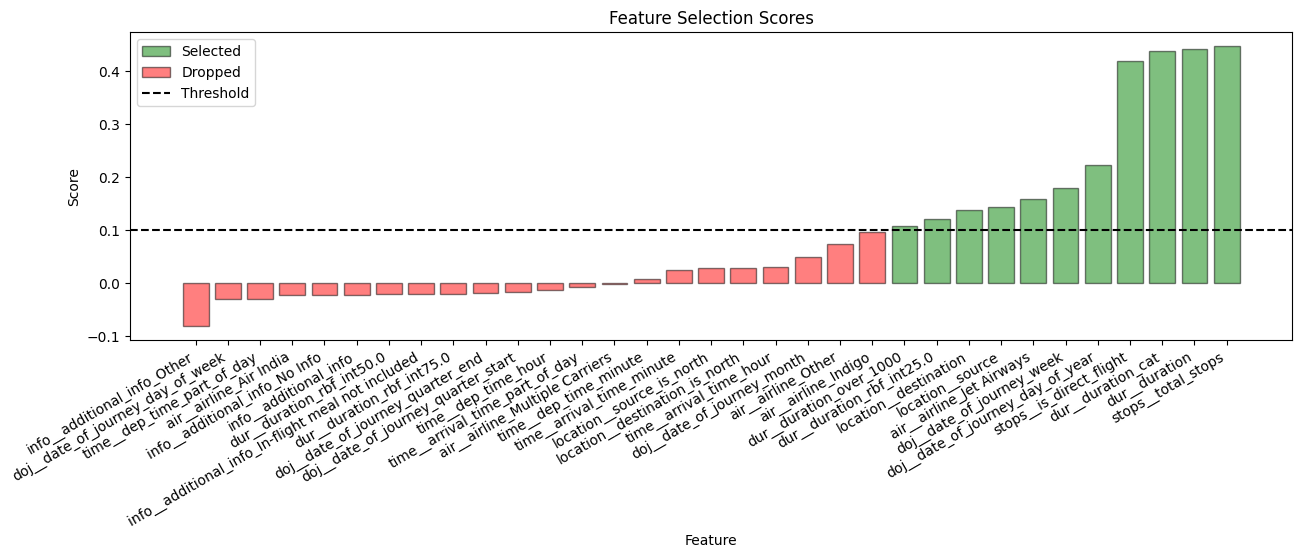

In [49]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

In [50]:
x_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']